In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
import scipy.io as sio
import torch
from tqdm import tqdm

In [2]:
#Read last hidden state vector generated by running DNABERT's prediction module
results = torch.load('outputs.pt')

#create arrays for labels, predictions, and final activation vectors

stacked_activation_vec = [results[0][2].detach().cpu().numpy().ravel()]
true_labels = [results[0][0][0]]
pred_labels = [np.argmax(results[0][1])]

# create an array for the opacity of each sample, to be used in t-SNE plot

opacity = [1]

#loop through each sample, append to array

for i in tqdm(range(1, len(results))):
    stacked_activation_vec.append(results[i][2].detach().cpu().numpy().ravel())
    pred_labels.append(np.argmax(results[i][1]))
    true_labels.extend(results[i][0])
    
    if true_labels[i] == pred_labels[i]:
        opacity.append(1)
    else:
        opacity.append(0.5)
        


len before stacking
1


100%|██████████| 9998/9998 [00:03<00:00, 2688.49it/s]


In [10]:
len(stacked_activation_vec)

9999

In [12]:
# t-SNE fit stacked activation vec

tsne = TSNE(n_components=2, verbose=1 ,perplexity= 30, n_iter=300, random_state=0)
tsne_results = tsne.fit_transform(stacked_activation_vec)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9999 samples in 0.975s...
[t-SNE] Computed neighbors for 9999 samples in 59.473s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9999
[t-SNE] Computed conditional probabilities for sample 2000 / 9999
[t-SNE] Computed conditional probabilities for sample 3000 / 9999
[t-SNE] Computed conditional probabilities for sample 4000 / 9999
[t-SNE] Computed conditional probabilities for sample 5000 / 9999
[t-SNE] Computed conditional probabilities for sample 6000 / 9999
[t-SNE] Computed conditional probabilities for sample 7000 / 9999
[t-SNE] Computed conditional probabilities for sample 8000 / 9999
[t-SNE] Computed conditional probabilities for sample 9000 / 9999
[t-SNE] Computed conditional probabilities for sample 9999 / 9999
[t-SNE] Mean sigma: 44.215249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.333725
[t-SNE] KL divergence after 300 iterations: 3.089919


In [13]:
# final activation vectors reduced to two dimensions with t-SNE

tsne_results

array([[ 3.0210073,  0.1432965],
       [-7.0866237,  2.8181484],
       [-3.956013 ,  1.3924392],
       ...,
       [ 4.1903853,  0.7820236],
       [-1.8078446,  1.2089387],
       [-0.2533215, -8.095442 ]], dtype=float32)

In [15]:
# convert from genome labels from DNABERT (genome1, genome2...) to species name

genome_labels = pd.read_csv('genome_to_id.tsv', sep='\t', header=None)
genome_labels_formatted = []

for label in genome_labels[1]:
    genome_labels_formatted.append(label.split('/')[-1][:-6])

In [16]:
#apply k-means with k=26 on above t-SNE results

kmeans = KMeans(26, random_state=0)
kmeans.fit(tsne_results)
identified_clusters = kmeans.fit_predict(tsne_results)
identified_clusters

array([24,  4, 23, ...,  0,  1, 14], dtype=int32)

In [17]:
# create separate arrays for correctly and incorrectly labeled samples

incorrect_tsne = []
correct_tsne = []

correct_labels = []
incorrect_labels = []

incorrect_clusters = []
correct_clusters = []



for i in range(len(tsne_results)):
    if true_labels[i] != pred_labels[i]:
        incorrect_tsne.append(tsne_results[i])
        incorrect_labels.append(true_labels[i])
        incorrect_clusters.append(identified_clusters[i])
    else:
        correct_tsne.append(tsne_results[i])
        correct_labels.append(true_labels[i])
        correct_clusters.append(identified_clusters[i])
        
incorrect_tsne = np.array(incorrect_tsne)
correct_tsne = np.array(correct_tsne)

incorrect_labels = np.array(incorrect_labels)
correct_labels = np.array(correct_labels)

incorrect_clusters = np.array(incorrect_clusters)
correct_clusters = np.array(correct_clusters)

In [18]:
incorrect_tsne

array([[ 9.308224 , -1.1327242],
       [ 6.2945347, -2.8037271],
       [ 2.6488082, -4.928466 ],
       ...,
       [ 6.683135 , -3.6431072],
       [ 2.806024 , -0.4120284],
       [ 4.1903853,  0.7820236]], dtype=float32)

      feature1  feature2  Clusters  true_labels  predicted_labels  opacity
0     3.021007  0.143296        24            6                 6      1.0
1    -7.086624  2.818148         4            6                 6      1.0
2    -3.956013  1.392439        23            6                 6      1.0
3     7.008677  3.863028        13            6                 6      1.0
4     1.498783  5.196490         3            6                 6      1.0
...        ...       ...       ...          ...               ...      ...
9994  2.091522  1.689710        24            6                 6      1.0
9995  7.334428  3.034324        13            6                 6      1.0
9996  4.190385  0.782024         0           25                 6      0.5
9997 -1.807845  1.208939         1            6                 6      1.0
9998 -0.253321 -8.095442        14           13                13      1.0

[9999 rows x 6 columns]


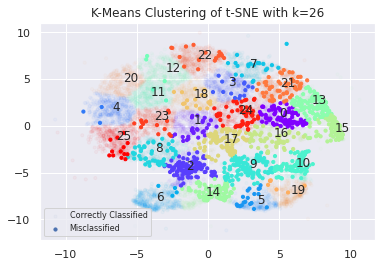

In [29]:
#create a dataframe with tSNE results and assigned cluster

data_with_clusters = pd.DataFrame(data = tsne_results, columns=['feature1', 'feature2'])
data_with_clusters['Clusters'] = identified_clusters
data_with_clusters['true_labels'] = true_labels
data_with_clusters['predicted_labels'] = pred_labels
data_with_clusters['opacity'] = opacity

print(data_with_clusters)

#scatter plot for t-SNE and k-means o/p
fig, ax = plt.subplots()

ax.scatter(correct_tsne[:,0], correct_tsne[:,1], c=correct_clusters, alpha=0.03, s=10, cmap='rainbow')
ax.scatter(incorrect_tsne[:,0], incorrect_tsne[:,1], c=incorrect_clusters, alpha=1, s=10, cmap='rainbow')


for i in range(26):
    ax.annotate(i, (kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]))
    
ax.title.set_text('K-Means Clustering of t-SNE with k=26')
ax.legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')

plt.savefig("svgplots2/opaque_kmeans_with_legend.svg", format="svg", bbox_inches='tight')

In [46]:
cluster_dataset = pd.DataFrame(columns=['Most Freq. Species', 'Majority Predicted Label', 'Correct Predictions', 'Incorrect Predictions', 'Total'])

for i in range(26):
    accurate_classifications = 0
    misclassifications = 0
    
    cluster_df = data_with_clusters[data_with_clusters['Clusters'] == i]
    for sample in cluster_df.iloc:
        if sample['true_labels'] == sample['predicted_labels']:
            accurate_classifications += 1
        else:
            misclassifications += 1
    
    cluster_dataset.loc[i] = [cluster_df['true_labels'].value_counts().idxmax(), cluster_df['predicted_labels'].value_counts().idxmax(), accurate_classifications, misclassifications, accurate_classifications + misclassifications]

In [50]:
cluster_dataset.loc[0]['Incorrect Predictions']

87

In [66]:
color_based_on_cluster_misclassifications = []

for i in range(len(data_with_clusters)):
    incorrect_predictions_ratio = cluster_dataset.loc[data_with_clusters.iloc[i]['Clusters']]['Incorrect Predictions'] / 125
    color_based_on_cluster_misclassifications.append(incorrect_predictions_ratio)
    
data_with_clusters['color_ratio'] = color_based_on_cluster_misclassifications
    
    
    

In [68]:
len(color_based_on_cluster_misclassifications)

9999

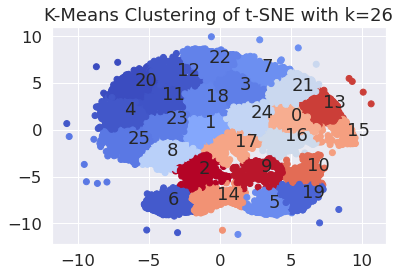

In [82]:
#scatter plot for t-SNE and k-means o/p
fig, ax = plt.subplots()

ax.scatter(data_with_clusters['feature1'], data_with_clusters['feature2'], c=data_with_clusters['color_ratio'], cmap='coolwarm')


for i in range(26):
    ax.annotate(i, (kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]))
    
ax.title.set_text('K-Means Clustering of t-SNE with k=26')
#ax.legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')

plt.savefig("svgplots2/kmeans_coolwarm_based_on_misclassification.svg", format="svg", bbox_inches='tight')

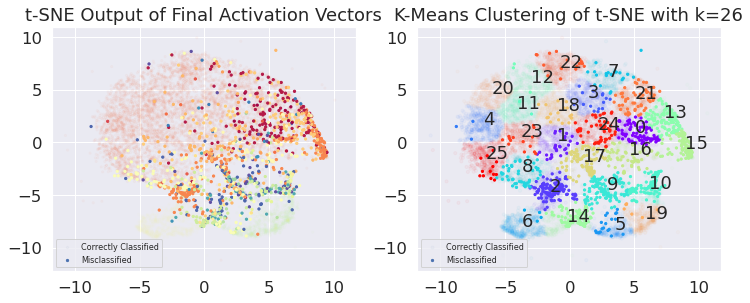

In [88]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(12, 4.5)


ax[0].set_title("t-SNE Output of Final Activation Vectors")

scatter = ax[0].scatter(correct_tsne[:,0], correct_tsne[:,1], c=correct_labels, alpha=0.03, s=5, cmap='Spectral')
scatter = ax[0].scatter(incorrect_tsne[:,0], incorrect_tsne[:,1], c=incorrect_labels, s=5, cmap='Spectral')

ax[1].scatter(correct_tsne[:,0], correct_tsne[:,1], c=correct_clusters, alpha=0.03, s=10, cmap='rainbow')
ax[1].scatter(incorrect_tsne[:,0], incorrect_tsne[:,1], c=incorrect_clusters, alpha=1, s=5, cmap='rainbow')


# ax[1].scatter(data_with_clusters['feature1'], data_with_clusters['feature2'], c=data_with_clusters['Clusters'], cmap='rainbow')

for i in range(26):
    ax[1].annotate(i, (kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]))
    
ax[1].title.set_text('K-Means Clustering of t-SNE with k=26')


# legend = ax.legend()

# Genome Legend
#legend = ax[0].legend(handles=scatter.legend_elements(num=26)[0], labels=genome_labels_formatted, fontsize=9.4, ncol=2, bbox_to_anchor=(2.2, -0.1))
#ax[0].add_artist(legend)
legend2 = ax[0].legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')

# legend = ax[1].legend(handles=scatter.legend_elements(num=26)[0], labels=genome_labels_formatted, fontsize=9.4, ncol=2, bbox_to_anchor=(2.2, -0.1))
# ax[1].add_artist(legend)
legend2 = ax[1].legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')

plt.savefig("svgplots2/sidebyside_opaque_kmeans1.svg", format="svg", bbox_inches='tight')


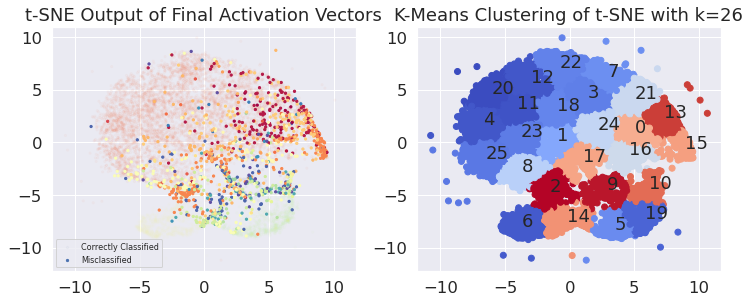

In [83]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(12, 4.5)


ax[0].set_title("t-SNE Output of Final Activation Vectors")

scatter = ax[0].scatter(correct_tsne[:,0], correct_tsne[:,1], c=correct_labels, alpha=0.03, s=5, cmap='Spectral')
scatter = ax[0].scatter(incorrect_tsne[:,0], incorrect_tsne[:,1], c=incorrect_labels, s=5, cmap='Spectral')

ax[1].scatter(data_with_clusters['feature1'], data_with_clusters['feature2'], c=data_with_clusters['color_ratio'], cmap='coolwarm')


# ax[1].scatter(data_with_clusters['feature1'], data_with_clusters['feature2'], c=data_with_clusters['Clusters'], cmap='rainbow')

for i in range(26):
    ax[1].annotate(i, (kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]))
    
ax[1].title.set_text('K-Means Clustering of t-SNE with k=26')


# legend = ax.legend()

# Genome Legend
# legend = ax[0].legend(handles=scatter.legend_elements(num=26)[0], labels=genome_labels_formatted, fontsize=9.4, ncol=2, bbox_to_anchor=(2.2, -0.1))
# ax[0].add_artist(legend)
legend2 = ax[0].legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')

#legend = ax[1].legend(handles=scatter.legend_elements(num=26)[0], labels=genome_labels_formatted, fontsize=9.4, ncol=2, bbox_to_anchor=(2.2, -0.1))
#ax[1].add_artist(legend)
# legend2 = ax[1].legend(labels=['Most Misclassifications', 'Least Misclassifications'], fontsize=8, ncol=1, loc='lower left')

plt.savefig("svgplots2/kmeans_sidebyside_coolwarm.svg", format="svg", bbox_inches='tight')


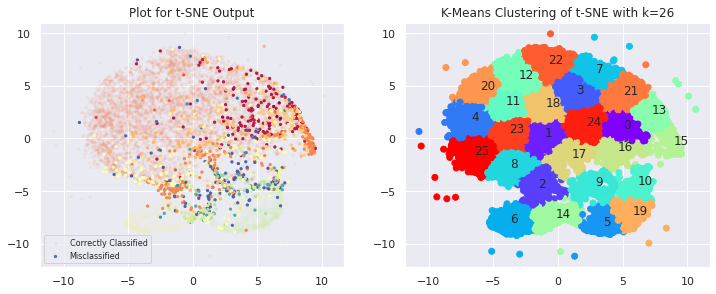

In [33]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(12, 4.5)


ax[0].set_title("Plot for t-SNE Output")
scatter = ax[0].scatter(correct_tsne[:,0], correct_tsne[:,1], c=correct_labels, alpha=0.05, s=5, cmap='Spectral')
scatter = ax[0].scatter(incorrect_tsne[:,0], incorrect_tsne[:,1], c=incorrect_labels, s=5, cmap='Spectral')

ax[1].scatter(data_with_clusters['feature1'], data_with_clusters['feature2'], c=data_with_clusters['Clusters'], cmap='rainbow')

for i in range(26):
    ax[1].annotate(i, (kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]))
    
ax[1].title.set_text('K-Means Clustering of t-SNE with k=26')


# legend = ax.legend()
#legend = ax[0].legend(handles=scatter.legend_elements(num=26)[0], labels=genome_labels_formatted, fontsize=9.4, ncol=2, bbox_to_anchor=(2.2, -0.1))
#ax[0].add_artist(legend)
legend2 = ax[0].legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')

plt.savefig("svgplots/sidebyside.svg", format="svg", bbox_inches='tight')


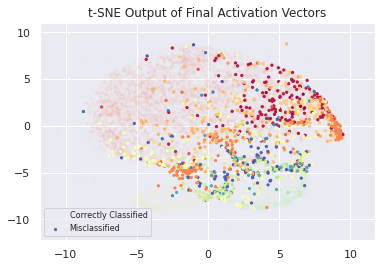

In [34]:

plt.title("t-SNE Output of Final Activation Vectors")
plt.scatter(correct_tsne[:,0], correct_tsne[:,1], c=correct_labels, alpha=0.02, s=5, cmap='Spectral')
plt.scatter(incorrect_tsne[:,0], incorrect_tsne[:,1], c=incorrect_labels, s=5, cmap='Spectral')
plt.legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')


plt.savefig('svgplots/tsneoutput-moretransparent.svg', format='svg')

In [35]:
data_with_clusters

,feature1,feature2,Clusters,true_labels,predicted_labels,opacity
0,3.021007,0.143296,24,6,6,1.0
1,-7.086624,2.818148,4,6,6,1.0
2,-3.956013,1.392439,23,6,6,1.0
3,7.008677,3.863028,13,6,6,1.0
4,1.498783,5.196490,3,6,6,1.0
...,...,...,...,...,...,...
9994,2.091522,1.689710,24,6,6,1.0
9995,7.334428,3.034324,13,6,6,1.0
9996,4.190385,0.782024,0,25,6,0.5
9997,-1.807845,1.208939,1,6,6,1.0


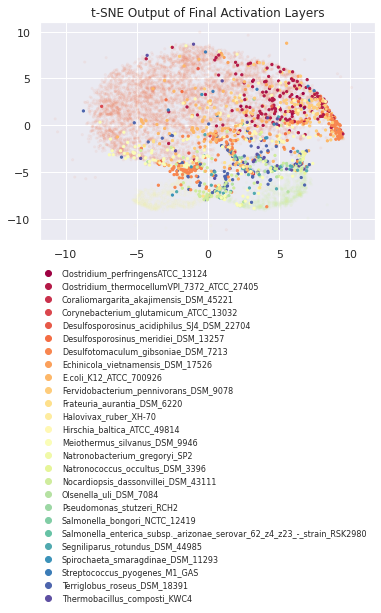

In [37]:

plt.title("t-SNE Output of Final Activation Layers")
plt.scatter(correct_tsne[:,0], correct_tsne[:,1], c=correct_labels, alpha=0.05, s=5, cmap='Spectral')
plt.scatter(incorrect_tsne[:,0], incorrect_tsne[:,1], c=incorrect_labels, s=5, cmap='Spectral')
plt.legend(labels=['Correctly Classified', 'Misclassified'], fontsize=8, ncol=1, loc='lower left')


plt.savefig('svgplots/tsneoutput.svg', format='svg')

legend = plt.legend(handles=scatter.legend_elements(num=26)[0], labels=genome_labels_formatted, fontsize=8, ncol=1, bbox_to_anchor=(1.0, -0.1), frameon=False)
# plt.add_artist(legend)

plt.savefig('svgplots/scatterplot_with_legend.svg', format='svg', bbox_inches='tight')


In [38]:
genomes_true_vs_pred = pd.DataFrame(columns=genome_labels_formatted)

for i in range(26):
    predictions = [0] * 26
    for j in range(len(true_labels)):
        if true_labels[j] == i:
            predictions[pred_labels[j]] += 1
    
    genomes_true_vs_pred.loc[genome_labels_formatted[i]] = predictions

In [39]:
genomes_true_vs_pred = genomes_true_vs_pred.astype(int)

In [40]:
for column_name in genomes_true_vs_pred.index:
    genomes_true_vs_pred.rename(columns={column_name: column_name[0:30] + ('...' if len(column_name) > 30 else '')}, index={column_name: column_name[0:30] + ('...' if len(column_name) > 30 else '')}, inplace=True)

    
display(genomes_true_vs_pred)

,Clostridium_perfringensATCC_13...,Clostridium_thermocellumVPI_73...,Coraliomargarita_akajimensis_D...,Corynebacterium_glutamicum_ATC...,Desulfosporosinus_acidiphilus_...,Desulfosporosinus_meridiei_DSM...,Desulfotomaculum_gibsoniae_DSM...,Echinicola_vietnamensis_DSM_17...,E.coli_K12_ATCC_700926,Fervidobacterium_pennivorans_D...,...,Nocardiopsis_dassonvillei_DSM_...,Olsenella_uli_DSM_7084,Pseudomonas_stutzeri_RCH2,Salmonella_bongori_NCTC_12419,Salmonella_enterica_subsp._ari...,Segniliparus_rotundus_DSM_4498...,Spirochaeta_smaragdinae_DSM_11...,Streptococcus_pyogenes_M1_GAS,Terriglobus_roseus_DSM_18391,Thermobacillus_composti_KWC4
Clostridium_perfringensATCC_13...,0,0,0,0,0,0,10,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Clostridium_thermocellumVPI_73...,0,14,0,0,0,0,129,0,2,12,...,0,0,0,0,0,0,0,0,0,0
Coraliomargarita_akajimensis_D...,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Corynebacterium_glutamicum_ATC...,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
Desulfosporosinus_acidiphilus_...,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Desulfosporosinus_meridiei_DSM...,0,0,0,0,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Desulfotomaculum_gibsoniae_DSM...,2,17,0,0,0,0,6448,0,32,66,...,3,0,0,0,0,0,0,0,11,4
Echinicola_vietnamensis_DSM_17...,0,1,0,0,0,0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E.coli_K12_ATCC_700926,0,1,0,0,0,0,83,0,123,0,...,2,0,0,0,0,0,0,0,11,2
Fervidobacterium_pennivorans_D...,1,4,0,0,0,0,139,0,2,156,...,0,0,0,0,0,0,0,0,0,0


In [41]:
import seaborn as sns
from matplotlib.colors import SymLogNorm, Normalize
from matplotlib import pyplot

/home/015861469/anaconda3/envs/dnabert/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  This is separate from the ipykernel package so we can avoid doing imports until


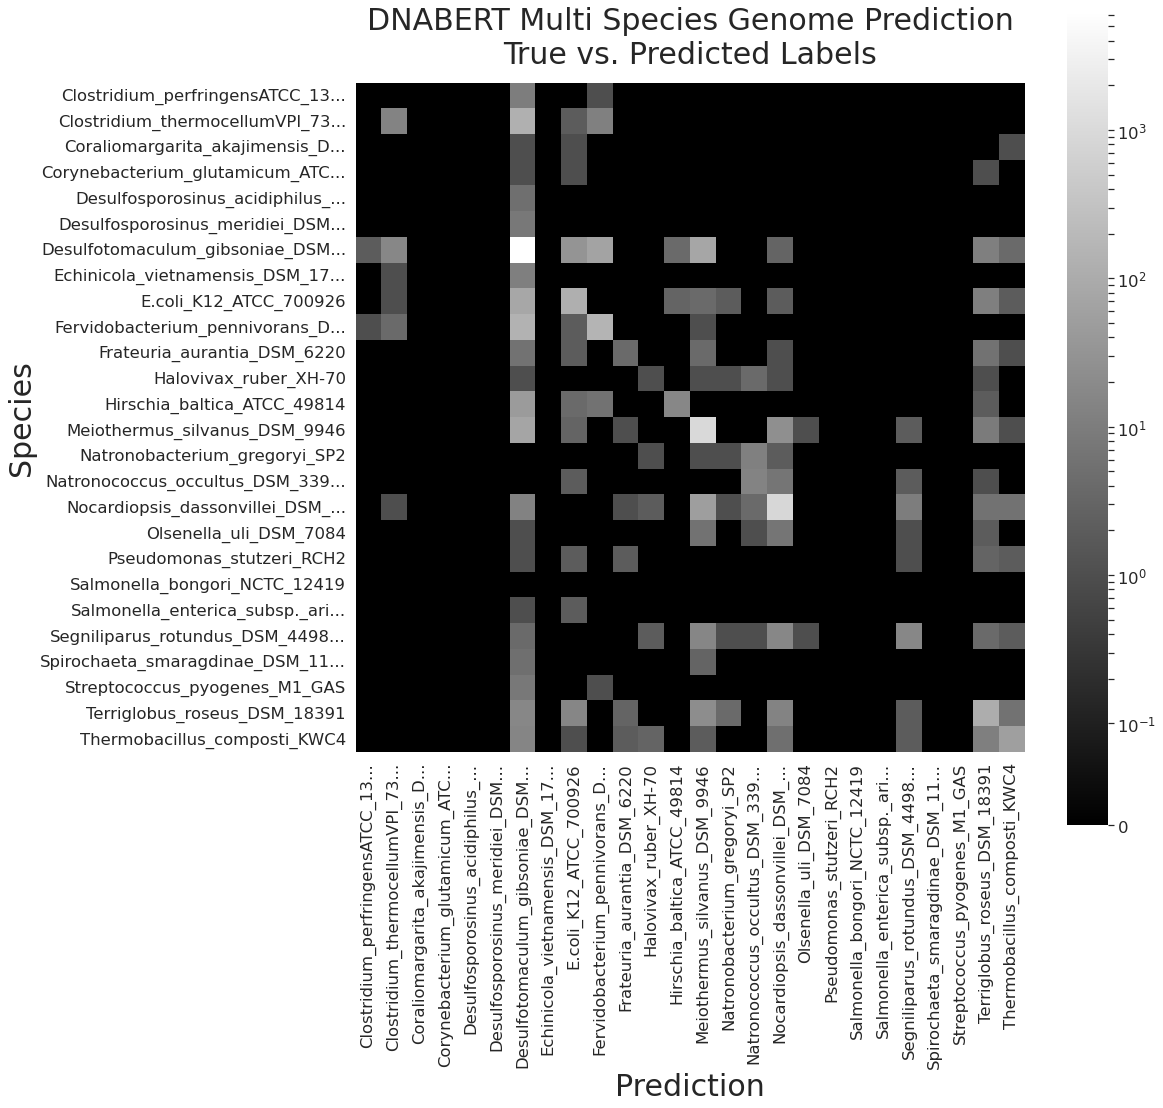

In [42]:
sns.set(font_scale=1.5)
pyplot.figure(figsize=(15, 15))
true_pred_heatmap = sns.heatmap(genomes_true_vs_pred, xticklabels=True, yticklabels=True, cmap='gray', square=True, norm=SymLogNorm(0.1))

_, xlabels = plt.xticks()
_, ylabels = plt.yticks()
# true_pred_heatmap.set_xticklabels(xlabels, size = 15, rotation=90)

plt.ylabel("Species", fontsize=30)
plt.xlabel("Prediction", fontsize=30)
plt.title("DNABERT Multi Species Genome Prediction\nTrue vs. Predicted Labels", fontdict={'fontsize':30}, pad = 20)

plt.savefig('svgplots/heatmap_gray.svg', format='svg', bbox_inches='tight')

In [ ]:
#apply t-SNE on activation vectors
#tsne = TSNE(n_components=2, verbose=1 ,perplexity= 30, n_iter=300)
#tsne_results = tsne.fit_transform(X_new)

#scatter plot - tSNE result



classes = []

for i in range(0, 27):
    classes.append(f'Genome {i}')

scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1],s= 5, c=true_labels, cmap='Spectral')
# apply legend()
plt.legend(handles=scatter.legend_elements(num=26)[0], labels=genome_labels_formatted, fontsize=8, ncol=1, bbox_to_anchor=(1.05, 1))
#add labels to axis

scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1],s= 5, c=true_labels, cmap='Spectral')

plt.xlabel('component 1')
plt.ylabel('component 2')
#add title to the plot
plt.title('t-SNE Output (true labels)', fontsize=18);
plt.show()

In [ ]:
classes

In [ ]:
from matplotlib.colors import ListedColormap

#scatter plot for missclassified data points in salmonella and Ecoli species
df_pred_lables = pd.read_csv ('/content/drive/MyDrive/DNA-BERT/CodeFiles/PredictedLabels_0and1.csv')
predicted_labels = df_pred_lables['Predictedvalue'].to_list()
print(predicted_labels)
missclassified_labels = []
x_cord = tsne_results[:,0]
y_cord = tsne_results[:,1]
print(type(x_cord))
print(type(y_cord))

#genearte a list of true and false ecoli and salmonella: true Ecoli = 0, false Salmonella = 1, true salmonella = 2, false Ecoli = 3
for i in range(len(predicted_labels)):
  if(predicted_labels[i] == 0 and labels[i] == 0):
    missclassified_labels.insert(i, 0)
  if(predicted_labels[i] == 1 and labels[i] == 0):
    missclassified_labels.insert(i, 1)
  if(predicted_labels[i] == 1 and labels[i] == 1):
    missclassified_labels.insert(i, 2)
  if(predicted_labels[i] == 0 and labels[i] == 1):
    missclassified_labels.insert(i, 3)
print(missclassified_labels)

#scatter plot for above list of labels
colors = ListedColormap(['r','b','y','g'])
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1],s= 5, c=missclassified_labels, cmap=colors)
#apply legend
classes = ['class Ecoli, pred Ecoli', 'class Ecoli, pred Salmonella', 'class Salmonella, pred Salmonella', 'class Salmonella, pred Ecoli']
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=classes, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#add labels to axis
plt.xlabel('component 1')
plt.ylabel('component 2')
#add title to the plot
plt.title('T-SNE plot of missclassification for Ecoli and Salmonella', fontsize=18);
plt.show()



In [56]:
data_with_clusters.sort_values("Clusters")

,feature1,feature2,Clusters,true_labels,predicted_labels
7898,5.188615,-0.025109,0,6,6
8121,4.938959,1.977745,0,6,6
1634,4.854575,0.233009,0,6,6
7604,5.592873,1.869458,0,6,6
308,4.943585,0.539190,0,6,6
...,...,...,...,...,...
2664,-7.708325,-1.799185,25,6,6
7614,-5.904146,-0.516044,25,6,6
2659,-7.246362,-0.767154,25,6,6
7629,-6.126198,-2.836004,25,6,6


In [58]:
cluster_dataset

,Most Freq. Species,Majority Predicted Label,Correct Predictions,Incorrect Predictions,Total
0,6,6,272,87,359
1,6,6,314,28,342
2,13,13,329,125,454
3,6,6,407,15,422
4,6,6,532,3,535
5,16,16,280,19,299
6,13,13,510,4,514
7,6,6,264,20,284
8,6,6,334,47,381
9,24,24,184,123,307


In [59]:
for i in range(26):
    cluster_df = data_with_clusters[data_with_clusters['Clusters'] == i]
    
    species_frequencies = cluster_df['true_labels'].value_counts().to_frame("Frequency")
    species_frequencies = species_frequencies.rename_axis("t")
    species_frequencies = species_frequencies.reset_index()
    species_frequencies.columns = ['Species', 'Frequency']
    
    species_frequencies.to_csv(f"species-frequencies/cluster{i}.csv")

In [60]:
list_of_cluster_means = kmeans.cluster_centers_



In [61]:
# Get top 3 and bottom 3 with incorrect and correct predictions

most_and_least = pd.concat([cluster_dataset.sort_values('Incorrect Predictions', ascending=False).iloc[:3], cluster_dataset.sort_values('Incorrect Predictions', ascending=False).iloc[-3:]])

In [62]:
most_and_least

,Most Freq. Species,Majority Predicted Label,Correct Predictions,Incorrect Predictions,Total
2,13,13,329,125,454
9,24,24,184,123,307
13,6,6,254,117,371
12,6,6,389,3,392
11,6,6,443,2,445
20,6,6,328,0,328


In [63]:
mean_dist_df = pd.DataFrame(columns=['Cluster No. 1', 'Cluster No. 2', 'Euclidean Dist. Between Means'])

for cluster in most_and_least.index:
    all_other_clusters = list(most_and_least.index)
    all_other_clusters.remove(cluster)
    
    for other_cluster in all_other_clusters:
        mean_dist = np.linalg.norm(list_of_cluster_means[cluster] - list_of_cluster_means[other_cluster])
        mean_dist_df.loc[len(mean_dist_df.index)] = [cluster, other_cluster, mean_dist]

In [64]:

# mean_dist_df = mean_dist_df.sort_values(['Cluster No. 1', 'Cluster No. 2'])
mean_dist_styler = mean_dist_df.style.hide_index()
mean_dist_styler.format({
    'Cluster No. 1': '{:.0f}'.format,
    'Cluster No. 2': '{:.0f}'.format,
})

mean_dist_styler

Cluster No. 1,Cluster No. 2,Euclidean Dist. Between Means
2,9,4.428981
2,13,11.268671
2,12,10.530813
2,11,8.309353
2,20,10.361379
9,2,4.428981
9,13,8.111524
9,12,11.804324
9,11,10.380612
9,20,12.756026


In [65]:
cluster_dataset.to_csv("table3.csv")
most_and_least.to_csv("most_and_least.csv")
mean_dist_df.to_csv("table6.csv")

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 16.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=953240e53de98585c7be86f81e8c6b0112d74068377716fe4c2ccd948d125076
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=888899413b4050265787aa1d668d85ab4a9b3b8f45a9fdae3602dba2017f5e58
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


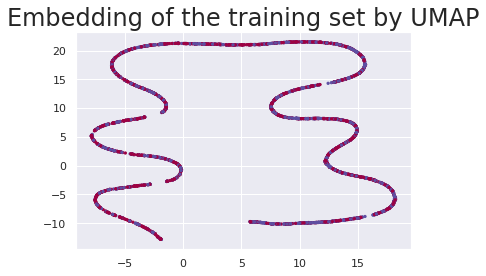

In [ ]:
#Compute and plot UMAP
import umap

trans = umap.UMAP(n_neighbors=50, random_state=42).fit(X_new)
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=labels, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);

In [ ]:
from sklearn.decomposition import PCA
principal=PCA(n_components=2)
principal.fit(X_new)
x_tranformed=principal.transform(X_new)
#scatter plot for 2 components
plt.figure(figsize=(6,6))
plt.scatter(x_tranformed[:,0],x_tranformed[:,1],s= 5, c=labels, cmap='Spectral')
plt.xlabel('pc1')
plt.ylabel('pc2')

NameError: ignored

Text(0, 0.5, 'pc2')

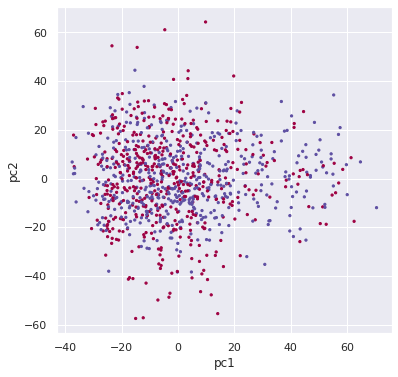